In [3]:
from autoML import autoML
import pandas as pd
import sklearn as sk
import numpy as np

## Loading the data

In [4]:
data = pd.read_csv("datasets/Fish.csv")
print(data.head())
print("Data shape:", data.shape)

  Species  Weight  Length1  Length2  Length3   Height   Width
0   Bream   242.0     23.2     25.4     30.0  11.5200  4.0200
1   Bream   290.0     24.0     26.3     31.2  12.4800  4.3056
2   Bream   340.0     23.9     26.5     31.1  12.3778  4.6961
3   Bream   363.0     26.3     29.0     33.5  12.7300  4.4555
4   Bream   430.0     26.5     29.0     34.0  12.4440  5.1340
Data shape: (159, 7)


## Split into test and training set

In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2)

train.shape, test.shape

((127, 7), (32, 7))

## Get knowledge over dataset

In [6]:
train.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
126,Perch,1000.0,40.2,43.5,46.0,12.6040,8.1420
138,Pike,567.0,43.2,46.0,48.7,7.7920,4.8700
142,Pike,1600.0,56.0,60.0,64.0,9.6000,6.1440
141,Pike,1250.0,52.0,56.0,59.7,10.6863,6.9849
8,Bream,450.0,27.6,30.0,35.1,14.0049,4.8438


The dataset has 7 attributes (incl. the target attribute *weight*). The attributes *Length1*, *Length2*, *Length3*, *Height* and *Width* are numerical. The attribute *Species* is nominal.

In [7]:
train.describe()

,Weight,Length1,Length2,Length3,Height,Width
count,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000
mean,396.793701,26.598425,28.772441,31.576378,8.899385,4.431364
std,345.549863,9.845319,10.544273,11.388698,4.170366,1.638092
min,0.000000,7.500000,8.400000,8.800000,1.738800,1.047600
25%,130.000000,19.600000,21.400000,23.500000,6.112300,3.467700
50%,290.000000,25.400000,27.500000,30.100000,7.680000,4.322500
75%,635.000000,32.750000,36.000000,39.650000,11.844900,5.472750
max,1600.000000,56.000000,60.000000,64.000000,18.754200,8.142000


In [8]:
set(train["Species"])

{'Bream', 'Parkki', 'Perch', 'Pike', 'Roach', 'Smelt', 'Whitefish'}

<AxesSubplot:ylabel='Species'>

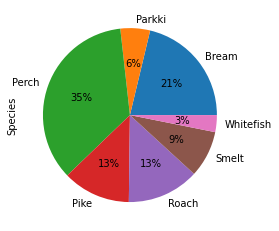

In [9]:
train.groupby("Species").size().plot.pie(ylabel="Species", autopct=lambda val: "{:0.0f}%".format(val))

<AxesSubplot:>

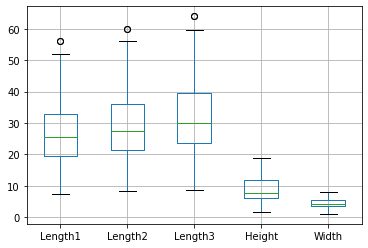

In [10]:
train.drop("Weight", axis=1).boxplot()

## Initialize all regressors

In [11]:
class DummyRegressor():
    def fit(self, X_train, y_train):
        self.range = min(y_train), max(y_train)
    
    def predict(self, X_test):
        return np.random.uniform(self.range[0], self.range[1], [len(X_test)])
    
    def get_params(self, deep=True):
        return {}      

regressors = {
    "dummy": DummyRegressor(),
    "decisionTree": sk.tree.DecisionTreeRegressor(),
    "linearRegression": sk.linear_model.LinearRegression(),
    "randomForestRegressor": sk.ensemble.RandomForestRegressor(),
    # our regressors
    "autoML": autoML(fitting_time=5, verbose=False),
}

## Check training performance

In [12]:
from sklearn.metrics import make_scorer

def relative_squared_error(y_pred, y_test):
    avg = np.average(y_test)
    error = y_pred-y_test
    mean_error = -(y_test-avg)
    return np.sum(error**2)/np.sum(mean_error**2)

def correlation_coefficient(y_pred, y_test):
    return np.corrcoef(np.array([y_pred, y_test]))[0][1]

def check_stats(predictor, X, y, name):
    
    scoring = {
        "MSE": make_scorer(sk.metrics.mean_absolute_error),
        "RSE": make_scorer(relative_squared_error),
        "CorrCoef": make_scorer(correlation_coefficient)
    }

    result = sk.model_selection.cross_validate(predictor, X, y, scoring=scoring)

    fit_time = np.mean(result["fit_time"])
    score_time = np.mean(result["score_time"])
    mse = np.mean(result["test_MSE"])
    rse = np.mean(result["test_RSE"])
    corr = np.mean(result["test_CorrCoef"])

    return name, mse, rse, corr, fit_time, score_time

In [13]:
def get_performance(regressors, X, y):
    # check stats of all regressors
    columns = ["Name", "MAE", "RSE", "Corr", "Fit time", "Score time"]
    rows = []
    for regressor_name in regressors:
        stats = check_stats(regressors[regressor_name], X, y, regressor_name)
        rows.append(stats)
    stats = pd.DataFrame(rows, columns=columns)
    return stats

### Preprocessing - Removing "Species"

In [14]:
X_rem = train.drop(["Weight", "Species"], axis=1)
y_rem = train["Weight"]

stats_rem = get_performance(regressors, X_rem, y_rem)
stats_rem

,Name,MAE,RSE,Corr,Fit time,Score time
0,dummy,573.057867,2.578154,-0.071160,0.000723,0.002094
1,decisionTree,49.631938,0.059903,0.972657,0.002617,0.001607
2,linearRegression,94.763651,0.166976,0.933744,0.018206,0.002335
3,randomForestRegressor,37.155427,0.039471,0.983184,0.087702,0.007663
4,autoML,79.778137,0.253044,0.962880,5.563653,0.010383


### Preprocessing - One-hot encoding "Species"

In [15]:
train_encoded = pd.get_dummies(train, columns=["Species"])
train_encoded.head()

,Weight,Length1,Length2,Length3,Height,Width,Species_Bream,Species_Parkki,Species_Perch,Species_Pike,Species_Roach,Species_Smelt,Species_Whitefish
126,1000.0,40.2,43.5,46.0,12.6040,8.1420,0,0,1,0,0,0,0
138,567.0,43.2,46.0,48.7,7.7920,4.8700,0,0,0,1,0,0,0
142,1600.0,56.0,60.0,64.0,9.6000,6.1440,0,0,0,1,0,0,0
141,1250.0,52.0,56.0,59.7,10.6863,6.9849,0,0,0,1,0,0,0
8,450.0,27.6,30.0,35.1,14.0049,4.8438,1,0,0,0,0,0,0


In [16]:
X_enc = train_encoded.drop("Weight", axis=1)
y_enc = train_encoded["Weight"]

stats_enc = get_performance(regressors, X_enc, y_enc)
stats_enc

,Name,MAE,RSE,Corr,Fit time,Score time
0,dummy,546.376728,2.365400,0.189072,0.001505,0.001437
1,decisionTree,50.075323,0.065305,0.969504,0.002871,0.002727
2,linearRegression,66.099895,0.081577,0.966112,0.002470,0.002758
3,randomForestRegressor,36.520445,0.040726,0.982665,0.099709,0.007557
4,autoML,105.575802,0.487417,0.971787,5.964883,0.011483


### Preprocessing - One-hot encoding + standardization

In [17]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X_enc)

X_std = pd.DataFrame(x_scaled, columns=X_enc.columns)
y_std = y_enc

X_std.index = y_std.index

stats_std = get_performance(regressors, X_std, y_std)
stats_std

,Name,MAE,RSE,Corr,Fit time,Score time
0,dummy,589.975019,2.568460,0.072358,0.000560,0.001012
1,decisionTree,53.184123,0.075550,0.964761,0.001892,0.003214
2,linearRegression,66.099895,0.081577,0.966112,0.002593,0.001893
3,randomForestRegressor,37.526896,0.039013,0.982679,0.099236,0.007710
4,autoML,112.249986,0.954747,0.958112,6.386839,0.014757


The performance checks show that the preprocessing step of one-hot encode the "Species" column is better than removing the column and has not real benefit over additional standardization.
Therefore one-hot encoding is enough.

## Checking performance on test set

In [18]:
from time import time

def get_test_performance(regressor, X, y):   
    t = time()
    y_pred = regressor.predict(X)
    t = time() - t
    
    mae = sk.metrics.mean_absolute_error(y_pred, y)
    rse = relative_squared_error(y_pred, y)
    corr = correlation_coefficient(y_pred,y)
    
    return mae, rse, corr, t
    

In [19]:
X_test

NameError: name 'X_test' is not defined

In [23]:
X_test = pd.get_dummies(test.drop("Weight", axis=1), columns=["Species"])
y_test = test["Weight"]

X_train = pd.get_dummies(train.drop("Weight", axis=1), columns=["Species"])
y_train = train["Weight"]

test_performance = []
for name in regressors:
    regressor = regressors[name]
    train_t = time()
    regressor.fit(X_train, y_train)
    train_t = time() - train_t
    mae, rse, corr, test_t = get_test_performance(regressor, X_test, y_test)
    test_performance.append((name, mae, rse, corr, train_t, test_t))

test_stats = pd.DataFrame(test_performance, columns=["Name", "MAE", "RSE", "CorrCoeff", "TrainTime", "TestTime"])
test_stats

ValueError: X has 10 features, but DecisionTreeRegressor is expecting 12 features as input.